# Developing and Executing Error-Mitigated NISQ Algorithms Across Devices and Simulators

**Dan Mills**, Melf Johannsen, Silas Dilkes - Cambridge Quantum

<daniel.mills@cambridgequantum.com>

## Tutorial Contents

Three parts, which will:
1. Explore the tools available in Tket, providing a comprehensive, feature-focused tour of the platform.
2. Introduce advanced usage of Tket, such as the development of bespoke compiler passes.
3. Exemplify the use of Qermit, a package for the use, composition and design of error-mitigation protocols.

## Part One

We will cover:
1. Installing and getting started with Tket and it's extensions.
2. Quantum gates, measurement and the construction of quantum circuits.
3. Steps required to prepare circuits to be run on a quantum computer.
4. Running circuits on quantum computers and classical simulators.
5. Tools that enable moving code between devices and software packages.

# The State of Quantum Computers and Software Development Kits

Noise:
- Noisy Intermediate-Scale Quantum &rarr; low numbers of qubits and high error rates.
- Error correction, break encryption, Grover's search &rarr; ❌

Operations:
- The devices will often only support a small fragment of quantum circuits.
- Only possible to perform multi-qubit operations between specific pairs of qubits.

Software:
- Utilisation of desirable devices may be locked behind specific interface software.

## What is tket?

Tket is a software platform for the development and execution of gate-level quantum computation. 

<p><em><center>It automatically handles many of the intricacies of NISQ technology.</center></em></p>

In Particular Tket:
- Noise and operations &rarr; Provides state-of-the-art performance in circuit compilation. 
- Software &rarr; Facilitates platform-agnostic software development, allowing code reuse.

<p><em><center> Frees the user to focus on the technique or project they are working on!</center></em></p>

## Getting Started

<p>There is currently an implementation of tket available in the form of the pytket python package.</p>
<p><center> <code> pip install pytket </code> </center></p>
<p>Additional extension modules are available for interfacing pytket with several quantum software packages, including: Qiskit, Cirq, pyQuil, and others.</p>
<p><center> <code> pip install pytket-qiskit </code> </center></p>
<p>Documentation and examples are available at <a href="https://cqcl.github.io/tket/pytket/api/">https://cqcl.github.io/tket/pytket/api/</a>.</p>

# How Are Quantum Circuits Constructed?

- Basic and advanced gates
- Measurement

## Basic Gates

Let's start by building a familiar circuit to generate the bell pair:
\\[ \left| \psi \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 00 \right\rangle + \left| 11 \right\rangle\right) \\]
The simplest way to build a circuit in pytket is by adding gates sequentially.

In bra-ket notation:
\\[ \mathsf{CX} ( \mathsf{H} \otimes \mathsf{I} ) \left| 00 \right\rangle = \mathsf{CX} \frac{1}{\sqrt{2}}\left( \left| 0 \right\rangle + \left| 1 \right\rangle \right) \left| 0 \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 00 \right\rangle + \left| 11 \right\rangle\right)\\]
where:
\\[ \mathsf{CX} = 
\begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & 1 & 0
\end{bmatrix}
\quad
\text{and}
\quad
\mathsf{H} = \frac{1}{\sqrt{2}}
\begin{bmatrix}
    1 & 1 \\
    1 & -1
\end{bmatrix}
\\]

The <code>Circuit</code> class is the unit of computation sent to a quantum processor.

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circ = Circuit(2)
circ.H(0).CX(0,1)

render_circuit_jupyter(circ)

Gates are added in order of execution. The circuit is typically assumed to act on the state \\(\left| 0^n \right\rangle\\), producing a new state at the end.

In [2]:
from pytket.extensions.qiskit import AerStateBackend
import numpy as np

backend = AerStateBackend()
result = backend.run_circuit(circ)
result_state = result.get_state()

print(f"State verctor -> {np.round(result_state, 3)}")

State verctor -> [0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


\\[ \left| \psi \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 00 \right\rangle + \left| 11 \right\rangle\right) \\]

Tket also includes a plethora of other gates, including:
- Paramterised gates &rarr; angle given first, and in units of \\( \pi \\).
- Control gates &rarr; control qubits given first, then target.

Less common gates available through <code>OpType</code> enum.

In [3]:
from pytket import OpType

circ = Circuit(3)

circ.Rx(0.5, 0)
circ.CRz(0.3, 1, 2)
circ.add_gate(OpType.CnX, [0, 2, 1])

render_circuit_jupyter(circ)

## Device Specific Gates

You'll find gate for a selection of devices in pytket. These include devices from Rigetti, IBM, OQC, Google, etc.

In the case of the HQS devices, an instance of the \\( \mathsf{ZZPhase} \\) is native.
\\[ \mathsf{ZZPhase} : \left( \alpha \right) \rightarrow e^{-\frac{1}{2} i \pi \alpha \mathsf{Z} \otimes \mathsf{Z}} = 
\begin{bmatrix}
    e^{-\frac{1}{2} i \pi \alpha} & 0 & 0 & 0\\
    0 & e^{\frac{1}{2} i \pi \alpha} & 0 & 0\\
    0 & 0 & e^{\frac{1}{2} i \pi \alpha} & 0\\
    0 & 0 & 0 & e^{-\frac{1}{2} i \pi \alpha}
\end{bmatrix} 
\\]
In particular \\( \mathsf{ZZPhase}\left( \frac{1}{2} \right) \\) is used, and can be accessed as the \\( \mathsf{ZZMax} \\) gate via pytket.

In [4]:
circ = Circuit(4)

circ.add_gate(OpType.ZZPhase, 0.7, [0, 2])
circ.add_gate(OpType.ZZMax, [1, 3])
circ.add_gate(OpType.PhasedX, [-0.1, 0.5], [3])

render_circuit_jupyter(circ)

## Universal gate sets

Native gates for devices are typically as subset of all quantum gates. However this set is *universal*. 
- A set of universal quantum gates is any set of gates to which any operation possible on a quantum computer can be reduced. 
- The Solovay–Kitaev theorem guarantees that any quantum operation can be efficiently approximated by a sequence of gates from this finite set.

The gate set \\( \{ \mathsf{ZZMax} , \mathsf{PhasedX} , \mathsf{Rx} \} \\), which is avilable on the HQS devices, is universal.

\\(\textsf{TK1}\\) and \\(\textsf{CNOT}\\) are together universal. Any single qubit gate can be implemented using the \\( \textsf{TK1} \\) gate.

\\[ \textsf{TK1} : \left( \alpha , \beta , \gamma \right) \rightarrow \textsf{RZ} \left( \alpha \right) \textsf{RX} \left( \beta \right) \textsf{RZ} \left( \gamma \right) \\]

In [5]:
angles = [0.1, 0.2, 0.3]

circ_tk = Circuit(1)
circ_tk.add_gate(OpType.TK1, angles, [0])
render_circuit_jupyter(circ_tk)

circ_r = Circuit(1)
circ_r.Rz(angles[2], 0).Rx(angles[1], 0).Rz(angles[0], 0)
render_circuit_jupyter(circ_r)

## Arbitrary Two Qubit Gates

As well as arbitrary single qubit gates, implemented via the \\( \textsf{TK1} \\) gate, pytket allows for arbitrary two qubit, and indeed three qubit, gates to be defined using unitary matrices.

In [6]:
from pytket.circuit import Unitary2qBox
from scipy.stats import unitary_group

x = unitary_group.rvs(4)
two_q_box = Unitary2qBox(x)
print(np.around(two_q_box.get_matrix(), 2))

[[-0.36-0.17j -0.56+0.23j  0.27-0.28j -0.11-0.56j]
 [-0.11-0.55j -0.4 +0.13j -0.61+0.03j  0.01+0.37j]
 [-0.17-0.j    0.37-0.13j -0.53-0.38j  0.42-0.47j]
 [-0.56+0.44j -0.26-0.49j -0.02-0.22j  0.05+0.37j]]


In [7]:
circ = Circuit(3).H(0).H(1).H(2)
circ.add_unitary2qbox(two_q_box, qubit_0=0, qubit_1=2)

render_circuit_jupyter(circ)

-0.355 - 0.171i,-0.558 + 0.229i,0.274 - 0.277i,-0.114 - 0.563i
-0.111 - 0.549i,-0.4 + 0.131i,-0.61 + 0.033i,0.013 + 0.37i
-0.166 - 0.001i,0.365 - 0.131i,-0.533 - 0.378i,0.419 - 0.469i
-0.555 + 0.442i,-0.262 - 0.491i,-0.018 - 0.222i,0.046 + 0.368i


In [8]:
from pytket.circuit import Unitary3qBox

circ = Circuit(3).H(0).H(1).H(2)

x = unitary_group.rvs(8)
unitary_circ = Unitary3qBox(x).get_circuit()
circ.add_circuit(unitary_circ, circ.qubits)

render_circuit_jupyter(circ)

## Measurement

Measurements produce classical data from the resulting state. 
- All measurements are single-qubit measurements in the \\( \mathsf{Z} \\) basis.
- Other forms of measurements can be constructed by combining these with other operations.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_state_probs(state):
    state_dict = {'State':[i for i in range(len(result_state))], 'Probability':abs(state)**2}
    state_df = pd.DataFrame(state_dict)
    sns.catplot(x='State', y='Probability', kind='bar', data=state_df, aspect = 3, height=2)
    plt.show()
    
def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x='State', y='Count', kind='bar', data=count_df, aspect = 3, height=2)
    plt.show()

State verctor -> [0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


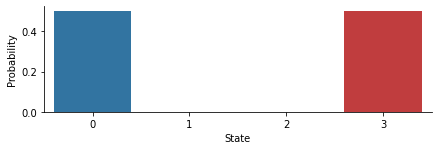

In [10]:
circ = Circuit(2).H(0).CX(0,1)

backend = AerStateBackend()
result_state = backend.run_circuit(circ).get_state()

render_circuit_jupyter(circ)
print(f"State verctor -> {np.round(result_state, 3)}")
plot_state_probs(result_state)

In [11]:
circ = Circuit(2,2).H(0).CX(0,1).measure_all()
render_circuit_jupyter(circ)

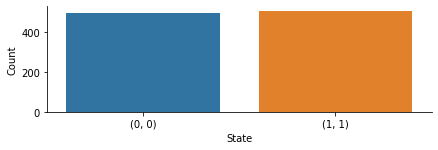

In [12]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
result_counts = backend.run_circuit(circ, n_shots=1000).get_counts()
plot_counts(result_counts)

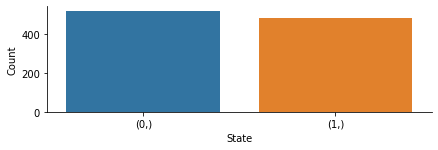

In [13]:
circ = Circuit(2,1).H(0).CX(0,1).Measure(1,0)
render_circuit_jupyter(circ)

backend = AerBackend()
result_counts = backend.run_circuit(circ, n_shots=1000).get_counts()
plot_counts(result_counts)

The first argument is the qubit to be measured and the second specifies the classical bit where the result is stored.

# Preparing and Running Quantum Circuits

In practice running on a real device is a little more complicated.
- So far we have used ideal classical simulators, which are noise free, do not have architectures, have a diverse gate set.

In [14]:
qft_circ=Circuit(3)

qft_circ.H(0)
qft_circ.CRz(0.5, 0, 1)
qft_circ.CRz(0.25, 0, 2)

qft_circ.H(1)
qft_circ.CRz(0.5, 1, 2)

qft_circ.H(2)

qft_circ.SWAP(0,2)

render_circuit_jupyter(qft_circ)

In [15]:
from pytket.extensions.qiskit import IBMQBackend
dev_b = IBMQBackend("ibmq_belem")
print(dev_b.backend_info.gate_set)

{<OpType.Rz: 32>, <OpType.U3: 33>, <OpType.U2: 34>, <OpType.U1: 35>, <OpType.CX: 37>, <OpType.X: 19>, <OpType.noop: 55>, <OpType.Measure: 56>, <OpType.Reset: 58>, <OpType.SX: 27>}


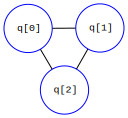

In [16]:
from pytket.utils import Graph
Graph(qft_circ).get_qubit_graph()

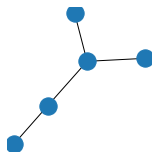

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(dev_b.backend_info.architecture.coupling)
plt.figure(figsize=(2,2))
nx.draw(G)
plt.show()

In [18]:
compiled_qft_circ = dev_b.get_compiled_circuit(qft_circ)
render_circuit_jupyter(compiled_qft_circ)

In [19]:
print("Gate set:", dev_b.backend_info.gate_set)

Gate set: {<OpType.Rz: 32>, <OpType.U3: 33>, <OpType.U2: 34>, <OpType.U1: 35>, <OpType.CX: 37>, <OpType.X: 19>, <OpType.noop: 55>, <OpType.Measure: 56>, <OpType.Reset: 58>, <OpType.SX: 27>}


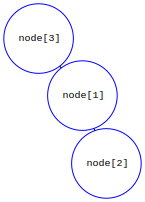

In [20]:
Graph(compiled_qft_circ).get_qubit_graph()

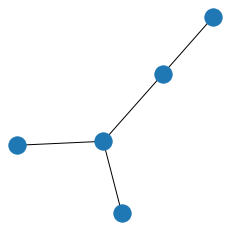

In [21]:
G = nx.Graph(dev_b.backend_info.architecture.coupling)
plt.figure(figsize=(3,3))
nx.draw(G)
plt.show()

# Importing, Exporting and Analysing Quantum Circuits

Tket allows users to:
- Export circuits to commonly accepted standard representations.
- Seamlessly move between software packages.
- Analyse circuits to gauge their complexity.

OpenQASM is one of the current industry standards for low-level circuit description languages and is widely supported. It servers as a platform-independent method of storing circuits. Tket has bidirectional conversion support for QASM.

In [22]:
from pytket.qasm import circuit_from_qasm, circuit_to_qasm, circuit_to_qasm_str

circ = circuit_from_qasm('example_circ.qasm')
render_circuit_jupyter(circ)

In [23]:
print(circuit_to_qasm_str(circ))

OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
t q[0];
cx q[2],q[3];
cx q[0],q[1];
t q[3];
cz q[0],q[2];
cz q[1],q[3];
t q[1];



Converters for other quantum software frameworks can optionally be included by installing the corresponding extension module. These are additional PyPI packages with names pytket-X.
<p><center> <code> pip install pytket-qiskit </code> </center></p>

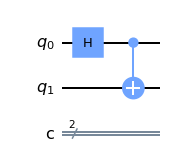

In [24]:
from qiskit import QuantumCircuit

qiskit_circ = QuantumCircuit(2, 2)

qiskit_circ.h(0)
qiskit_circ.cx(0, 1)

qiskit_circ.draw(output='mpl')

In [25]:
from pytket.extensions.qiskit import qiskit_to_tk

tket_circ = qiskit_to_tk(qiskit_circ)
tket_circ.measure_all()

render_circuit_jupyter(tket_circ)

In [26]:
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit import Aer
from qiskit import assemble

sv_sim = Aer.get_backend('aer_simulator')

tket_circ = Circuit(3).X(0).H(2).CX(0,1)
qiskit_circ = tk_to_qiskit(tket_circ)
qiskit_circ.measure_all()

qobj = assemble(qiskit_circ, shots=1000)
job = sv_sim.run(qobj)
hist = job.result().get_counts()
print(hist)

{'111': 507, '011': 493}


/opt/miniconda3/envs/public/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


## Circuit Analysis

Common circuit metrics like gate count and depth are used to approximate the difficulty of running it on a device, providing some basic tools to help distinguish different implementations of a given algorithm.
- On NISQ technology two-qubit gates being much slower and noisier.
- Looking forward to the fault-tolerant regime, we will expect Clifford gates to be very cheap, but the T gate to require an expensive distillation procedure.

In [27]:
print(f"Number of gates = {circ.n_gates}")
print(f"Circuit depth = {circ.depth()}")
print(f"Number of T gates = {circ.n_gates_of_type(OpType.T)}")

Number of gates = 7
Circuit depth = 4
Number of T gates = 3


# Max-Cut Problem 

Consider a graph, consisting of verticies and edges connecting them. A cut of such a graph is a partition of the vertices of the graph into two sets. Max-cut is the problem of finding a partition which maximises the number of edges between the two sets.

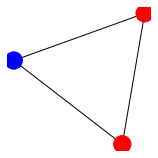

In [28]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,0)])
plt.figure(figsize=(2,2))
nx.draw(G, node_color=['red', 'blue', 'red'])
plt.show()

There are \\(2^3\\) possible assignments of colour to nodes. In general there are \\( 2^n \\). The Max-cut problem can then be stated as that of finding the colour assignment which maximises the number of edges between vertices of a different colour.

## Quantum Approximate Optimization Algorithm (QAOA)

Introduced in 'A Quantum Approximate Optimization Algorithm' (found at https://arxiv.org/abs/1411.4028). The idea is to prepare a quantum state which encodes a solution to the Max-cut problem. This is a variational algorithm, which is to say that a paramaterised state is prepared, with the paramaters varied to improve the solution. In particular, the state prepared has the form 
\\[ \left| \psi \left( \beta, \gamma \right) \right\rangle = U \left( \beta_m \right) U \left( \gamma_m \right) ... U \left( \beta_0 \right) U \left( \gamma_0 \right) \left| \psi_0 \right\rangle \\]
where
\\[ U \left( \beta_i \right) = e^{i \beta H_B} \quad \& \quad U \left( \gamma_i \right) = e^{i \gamma H_P} \\]
with \\( H_B \\) and \\( H_P \\) depending on the problem instance. 

In this case the *problem Hamiltonian* is
\\[ H_P = \frac{1}{2 \sqrt{2}} \left[ \left( Z \otimes Z \otimes I \right) + \left( Z \otimes I \otimes Z \right) + \left( I \otimes Z \otimes Z \right) \right] \\]
where you will notice that there is a \\( Z \otimes Z \\) acting between each vertex which is connected by an edge.

The *mixer Hamiltonian* has the form 
\\[ H_B = \frac{1}{2 \sqrt{2}} \left[ \left( X \otimes I \otimes I \right) + \left( I \otimes X \otimes I \right) + \left( I \otimes I \otimes X \right) \right] \\]
where you will notice that there is an \\( X \\) acting on each vertex.

## Symbolic Gates

It is very common for an experiment to use many circuits with similar structure, but varying gate parameters. In variational algorithms like QAOA, we are trying to explore the energy landscape with respect to the circuit parameters. 
- The only differences between iterations of the optimisation procedure are the specific angles of rotations in the circuits. 
- Because the procedures of generating and compiling the circuits typically won’t care what the exact angles are, we can define the circuits abstractly, treating each parameter as an algebraic symbol. 
- sympy is a widely-used python package for symbolic expressions and algebraic manipulation, defining sympy.Symbol objects to represent algebraic variables and using them in sympy.Expression s to build mathematical statements and arithmetic expressions.

## Mixing Unitary

In [29]:
from pytket import Circuit
from pytket.circuit import PauliExpBox
from pytket.circuit import Pauli
from pytket.passes import DecomposeBoxes
from sympy import Symbol

mixing_circ = Circuit(len(G.nodes()))
beta = Symbol("beta")

for node in list(G.nodes()):
    
    paulis = [Pauli.I] * len(G.nodes())
    paulis[node] = Pauli.X
    
    pauli_exp_box = PauliExpBox(paulis=paulis, t=beta)
    mixing_circ.add_pauliexpbox(pauli_exp_box, list(G.nodes()))

DecomposeBoxes().apply(mixing_circ)
render_circuit_jupyter(mixing_circ)

## Problem Unitary

In [30]:
problem_circ = Circuit(len(G.nodes()))
gamma = Symbol("gamma")

for edge in list(G.edges()):
        
    paulis = [Pauli.I] * len(G.nodes())
    paulis[edge[0]] = Pauli.Z
    paulis[edge[1]] = Pauli.Z
    
    pauli_exp_box = PauliExpBox(paulis=paulis, t=gamma)
    problem_circ.add_pauliexpbox(pauli_exp_box, list(G.nodes()))

DecomposeBoxes().apply(problem_circ)
render_circuit_jupyter(problem_circ)

## QAOA Circuit

In [31]:
circ = Circuit(len(G.nodes()))

for node in list(G.nodes()):
    circ.H(node)
circ.add_barrier(list(G.nodes()))  

circ.append(problem_circ)
circ.add_barrier(list(G.nodes()))  

circ.append(mixing_circ)

s_map = {beta:1.25, gamma:0.5}
circ.symbol_substitution(s_map)

render_circuit_jupyter(circ)

<center> <h1> Questions </h1> </center>